In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Use importlib to handle 'kicad-coil-plugins' being a package with dashes in it
import importlib
pcb_helpers = importlib.import_module("kicad-coil-plugins.helpers")
pcb_json = importlib.import_module("kicad-coil-plugins.pcb_json")

## Various tunable constants

In [2]:
ID = 53 # Inner diameter in mm
OD = 79 # Outer diameter in mm
POLES = 36 # Also often referred to as Slots. Calulate this based on the github documentation

#Don't edit this value directly, edit POLES instead
POLE_SUBDIVISIONS = 6 #first for outer, second for space, third for space, fourth for inner, fifth for space, sixth for space

if POLES % POLE_SUBDIVISIONS != 0:
    raise ValueError("SLOTS must be a multiple of 6")

POLE_DIV_6 = POLES // POLE_SUBDIVISIONS
INNER_TRACE_WIDTH = 0.24
INNER_TRACE_WIDTH_2 = 0.26
TRACE_WIDTH = 0.29 # 5mil = 0.127, rounded up for FOV
TRACE_SPACING = 0.172
LINK_SPACING = 0.23
LINK_WIDTH_OUTER = 0.45 # this is the width of the link between the inner and outer traces
LINK_WIDTH_INNER = 0.4


# via defaults
VIA_DIAM = 0.32
VIA_DRILL = 0.25

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

INNER_CIRCUMFERENCE = ID*math.pi
OUTER_CIRCUMFERENCE = OD*math.pi


In [3]:
POLE_ANGLE = 360/POLE_DIV_6
POLE_SUBDIVISION_ANGLE = POLE_ANGLE/POLE_SUBDIVISIONS
INNER_SUBDIVISION_CIRCUMFERENCE = INNER_CIRCUMFERENCE * (POLE_SUBDIVISION_ANGLE/360)
TRACE_PER_POLE_RAW = INNER_SUBDIVISION_CIRCUMFERENCE/(TRACE_WIDTH + TRACE_SPACING)
TRACE_PER_POLE_ROUND = math.floor(TRACE_PER_POLE_RAW)
print("Trace lines: ", TRACE_PER_POLE_RAW)
print("Pole subdivision angle",POLE_SUBDIVISION_ANGLE)

Trace lines:  10.011087700833276
Pole subdivision angle 10.0


The next section of code will calculate the nearest (smaller) Inner diameter that will allow for a round number of traces. One can go back and tune the Inner/Outer diameter and Poles constants above to get acceptable numbers

In [4]:
# calculate a smaller inner circumfrence to get a whole number of traces
TRACES_NEEDED = math.floor(TRACE_PER_POLE_RAW) 
TRACE_CIRCUMFERENCE_NEEDED = TRACES_NEEDED * (TRACE_WIDTH + TRACE_SPACING)
TOTAL_INNER_CIRCUMFERENCE_NEEDED = TRACE_CIRCUMFERENCE_NEEDED * POLE_DIV_6 * POLE_SUBDIVISIONS
NEW_ID = TOTAL_INNER_CIRCUMFERENCE_NEEDED/math.pi

print("New ID: ", NEW_ID)

TRACE_ANGLE = POLE_SUBDIVISION_ANGLE/TRACES_NEEDED

print("Trace angle: ", TRACE_ANGLE)

New ID:  52.94130027008806
Trace angle:  1.0


# Plotting of the actual PCB Traces

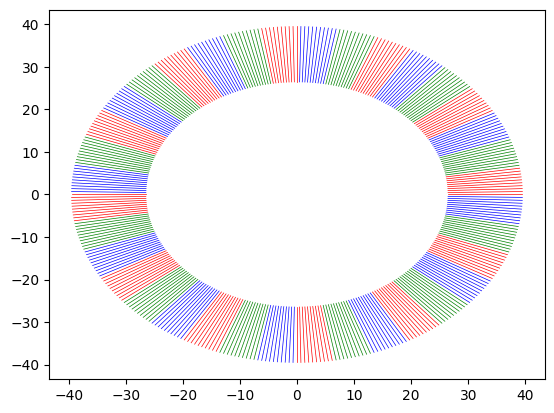

In [5]:
tracks_a = []
tracks_b = []
tracks_c = []
tracks_d = []

tracks = {"red": tracks_a, "green": tracks_b, "blue": tracks_c, "back": tracks_d}

vias = []
# plt.figure(dpi = 300)
for pole in range(POLE_DIV_6):
    for subdivision in range(POLE_SUBDIVISIONS):
        count = 0
        for trace in range(TRACES_NEEDED):
            # macro segment -> subdivision (akin to phase) -> trace
            angle = (pole*POLE_ANGLE) + (subdivision*POLE_SUBDIVISION_ANGLE) + ((trace/TRACES_NEEDED) * POLE_SUBDIVISION_ANGLE)
            # angle = angle + (phase*40)
            x_start = (NEW_ID/2) * math.cos(math.radians(angle))
            y_start = (NEW_ID/2) * math.sin(math.radians(angle))
            x_end = (OD/2) * math.cos(math.radians(angle))
            y_end = (OD/2) * math.sin(math.radians(angle))
            # plot a line from x_start, y_start to x_end, y_end
            if subdivision == 0 or subdivision == 3:
                color = 'red'
                plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=0.5)
            elif subdivision == 1 or subdivision == 4: 
                color = 'green'
                plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=0.5)
            elif subdivision == 2 or subdivision == 5:
                color = 'blue'
                plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=0.5)

            # draw the trace
            trace_base = ({
                "net": color,
                "width": TRACE_WIDTH,
                "pts": [
                    (x_start, y_start),
                    (x_end, y_end)
                ]
            })
            tracks['blue'].append(trace_base)
            tracks['green'].append(trace_base)
            tracks['red'].append(trace_base)
            tracks['back'].append(trace_base)
            # if subdivision == 0 or subdivision == 3:
            #     tracks['red'].append(trace_base)

            # add vias to the track start and end points
            vias.append(pcb_json.create_via((x_start, y_start), color)) 
            vias.append(pcb_json.create_via((x_end, y_end), color))


            # calculate the angle of the link
            if TRACES_NEEDED % 2 == 0:
                angle_modifier = ((((TRACES_NEEDED/2) - (trace + 1)) * 2) + 1) * TRACE_ANGLE
                target_trace_angle = angle + (POLE_SUBDIVISION_ANGLE * 3) + (angle_modifier)
            if TRACES_NEEDED % 2 == 1:
                angle_modifier = (((TRACES_NEEDED - 1)/2) - trace) * TRACE_ANGLE
                target_trace_angle = angle + (POLE_SUBDIVISION_ANGLE * 3) + (angle_modifier * 2)

            # handle overlap of coils
            final_coil_flag = False
            if pole == POLE_DIV_6 - 1 and subdivision in [0,1,2]:
                final_coil_flag = True

            if final_coil_flag:
                target_trace_angle -= TRACE_ANGLE

            ###

            start_angle_full = angle 
            end_angle_full = target_trace_angle

            start_angle_no_curve = (pole*POLE_ANGLE) + ((subdivision + 1)*POLE_SUBDIVISION_ANGLE)
            end_angle_no_curve = start_angle_no_curve + (2*POLE_SUBDIVISION_ANGLE) - (TRACE_ANGLE)

            weights = [0.66, 0.33]
            start_angle = np.average([start_angle_full, start_angle_no_curve], weights = weights)
            end_angle = np.average([end_angle_full, end_angle_no_curve], weights = weights)

            if subdivision in [0,1,2]:
                LINK_WIDTH = LINK_WIDTH_OUTER
                radius = (OD/2) + ((LINK_WIDTH + LINK_SPACING) * (TRACES_NEEDED + 1)) - (count * (LINK_WIDTH + LINK_SPACING))
            if subdivision in [3,4,5]:
                LINK_WIDTH = LINK_WIDTH_INNER
                radius = (NEW_ID/2) - ((LINK_WIDTH + LINK_SPACING) * (TRACES_NEEDED + 1)) + (count * (LINK_WIDTH + LINK_SPACING))

            tracks[color].append({
                "net": color,
                "width": LINK_WIDTH,
                "pts": pcb_helpers.draw_arc(
                        start_angle = start_angle,
                        end_angle = end_angle,
                        radius = radius
                    )
                }
            )
            count += 1

            # draw the connection between the trace and the link
            if subdivision in [0,1,2]:
                trace_position = (x_end, y_end)
                link_position = tracks[color][-1]["pts"][0]
                
                # linear extension
                # extension_length = 0.5 * ((TRACES_NEEDED - trace)/TRACES_NEEDED) * ((OD/2) + ((LINK_WIDTH + TRACE_SPACING) * (TRACES_NEEDED + 1)))
                extension_length = 0.25 * ((radius*2) - OD)
                extension_x = extension_length * math.cos(math.radians(angle))
                extension_y = extension_length * math.sin(math.radians(angle))

                tracks[color].append({
                    "net": color,
                    "width": LINK_WIDTH,
                    "pts": [
                        trace_position,
                        (extension_x + x_end, extension_y + y_end)
                    ]
                })

                # do a 45 degree elbow to the link 
                tracks[color].append({
                    "net": color,
                    "width": LINK_WIDTH,
                    "pts": [
                        (extension_x + x_end, extension_y + y_end),
                        link_position
                    ]
                })

                # repeat for the end of link side
                link_end_position = tracks[color][-3]["pts"][-1]
                rotated_trace_position = pcb_helpers.rotate_point(x_end, y_end, target_trace_angle - angle)
                extension_x = extension_length * math.cos(math.radians(target_trace_angle))
                extension_y = extension_length * math.sin(math.radians(target_trace_angle))

                # avoid short circuit to other links
                if (final_coil_flag) and (trace == (TRACES_NEEDED - 1)):
                    continue

                tracks[color].append({
                    "net": color,
                    "width": LINK_WIDTH,
                    "pts": [
                        rotated_trace_position,
                        (rotated_trace_position[0] + extension_x, rotated_trace_position[1] + extension_y)
                    ]
                })

                tracks[color].append({
                    "net": color,
                    "width": LINK_WIDTH,
                    "pts": [
                        (rotated_trace_position[0] + extension_x, rotated_trace_position[1] + extension_y),
                        link_end_position
                    ]
                })

                
            if subdivision in [3,4,5]:
                trace_position = (x_start, y_start)
                link_position = tracks[color][-1]["pts"][0]
                
                # linear extension
                extension_length = 0.25 * (ID - (radius*2))
                extension_x = extension_length * math.cos(math.radians(angle))
                extension_y = extension_length * math.sin(math.radians(angle))

                tracks[color].append({
                    "net": color,
                    "width": INNER_TRACE_WIDTH_2,
                    "pts": [
                        trace_position,
                        (x_start - extension_x, y_start - extension_y)
                    ]
                })

                # do a 45 degree elbow to the link 

                tracks[color].append({
                    "net": color,
                    "width": INNER_TRACE_WIDTH,
                    "pts": [
                        (x_start - extension_x, y_start - extension_y),
                        link_position
                    ]
                })

                # repeat for the end of link side
                link_end_position = tracks[color][-3]["pts"][-1]
                rotated_trace_position = pcb_helpers.rotate_point(x_start, y_start, target_trace_angle - angle)
                extension_x = extension_length * math.cos(math.radians(target_trace_angle))
                extension_y = extension_length * math.sin(math.radians(target_trace_angle))

                
                tracks[color].append({
                    "net": color,
                    "width": INNER_TRACE_WIDTH_2,
                    "pts": [
                        rotated_trace_position,
                        (rotated_trace_position[0] - extension_x, rotated_trace_position[1] - extension_y)
                    ]
                })

                tracks[color].append({
                    "net": color,
                    "width": INNER_TRACE_WIDTH,
                    "pts": [
                        (rotated_trace_position[0] - extension_x, rotated_trace_position[1] - extension_y),
                        link_end_position
                    ]
                })


    # if pole == 0:
    #     break
            
# plt.show()


## Exporting the generated coil design

In [6]:
pins = []
pads = []
silk = []
tracks_in = []
tracks_f = []
tracks_b = []
mounting_holes = []
edge_cuts = []

json_result = pcb_json.dump_json(
    filename='coil_output.json',
    track_width=TRACE_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks['red'],
    tracks_in=[tracks['blue'], tracks['green']],
    tracks_b=tracks['back'],
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
    components=[],
)
# 

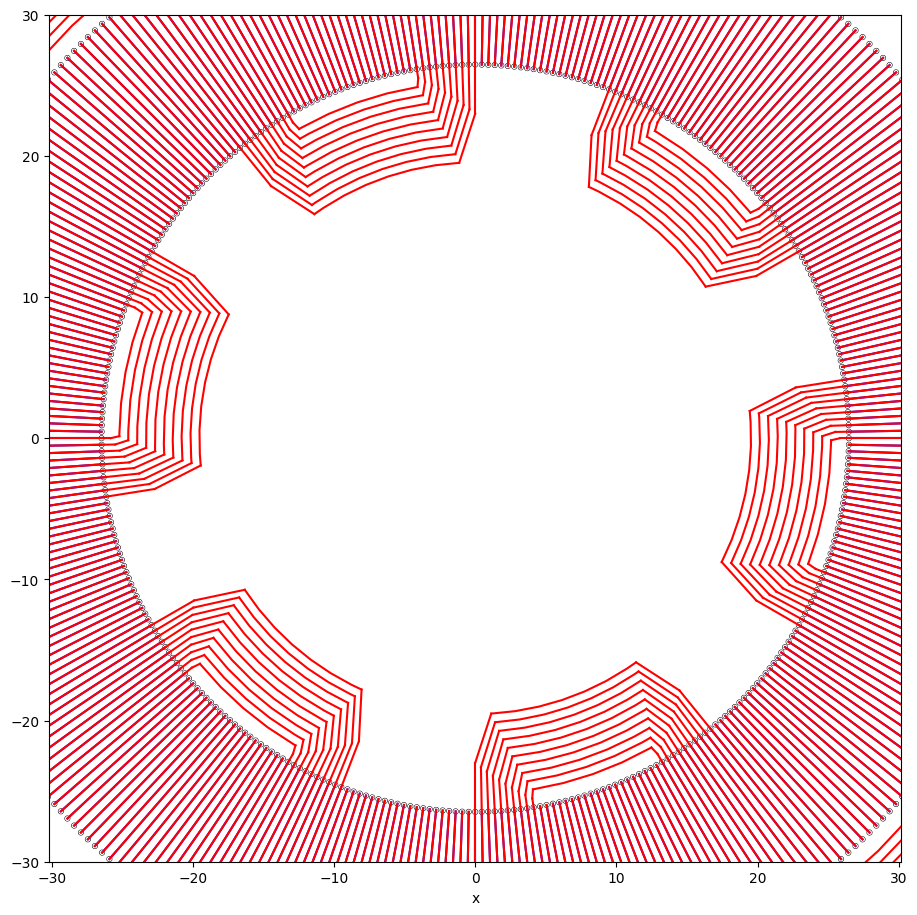

In [7]:
pcb_json.plot_json(json_result)